In [2]:
from KRI import Dataset
import pandas as pd
import lightgbm as lgb
import numpy as np
from util import sfl_defaults
import matplotlib.pyplot as plt

sfl_defaults()

# c10 = Dataset(path='../../Data/c10/')
# c11 = Dataset(path='../../Data/c11/')
# c12 = Dataset(path='../../Data/c12/')
# c13 = Dataset(path='../../Data/c13/')
# c15 = Dataset(path='../../Data/c15/')

c10 = Dataset(schema='Clintek_010')
c11 = Dataset(schema='Clintek_011')
c12 = Dataset(schema='Clintek_012')
c13 = Dataset(schema='Clintek_013')
c15 = Dataset(schema='Clintek_015')
# print(c10)


dfs= [c10, c11, c12, c13, c15]

Data Loaded
Data Loaded
Data Loaded
Data Loaded
Data Loaded


In [3]:
for df in dfs:
    last_day = int(df._site_active.EndDay.max())
    print(last_day)
    df.score_all(0, last_day, 100)

1568
143
767
6617
365


In [4]:
out = []
for df in dfs:
    df_out = []
    print(df)
    for site in df._site_list:
        temp = []
        for KRI_df_name in ['Safety', "Data_Quality", "IP_Management", "SB_Management", "LB_Management"]:
            KRI_df = getattr(df, KRI_df_name)
            if not KRI_df.empty:
                for KRI_type in KRI_df.KRI_Type.unique():
                    temp.append(KRI_df[(KRI_df.KRI_Type == KRI_type) & (KRI_df.Site == site)][['Start_Time', 'Value']].rename({'Value': KRI_type}, axis=1))


        site_table = pd.DataFrame()

        for temp_df in temp:
            if site_table.empty:
                site_table = temp_df
            else:
                site_table = site_table.merge(temp_df, on = 'Start_Time')

        site_table = site_table.interpolate()

        site_table['Site'] = site
        site_table['Survive'] = 1
        site_table.Survive.iloc[-1] = 0
        df_out.append(site_table)

    df_out = pd.concat(df_out)
    print(f'{df_out.shape[0]} rows')
    out.append(df_out)

254 rows
17 rows
85 rows
144 rows
8 rows


In [5]:
out = pd.concat(out)

In [6]:
out

Start_Time  AE_per_active_subject  SAE_per_active_subject  \
0            0               5.000000                0.000000   
1          100               2.000000                0.000000   
2          200               3.000000                0.000000   
3          300               5.000000                1.000000   
4          400               2.000000                0.000000   
..         ...                    ...                     ...   
3          300              12.000000                0.000000   
0            0              24.928571                0.428571   
1          100              13.500000                0.600000   
2          200               7.000000                1.500000   
3          300              10.000000                0.000000   

    RAE_per_active_subject  SRAE_per_active_subject  IP_variance  Missed_Dose  \
0                      3.5                      0.0    23.197657          4.0   
1                      0.0                      0.0     0.000000          0.0   
2                      0.0                      0.0     0.000000          0.0   
3                      0.0                      0.0    11.338934          1.0   
4                      1.0                      0.0     0.000000          0.0   
..                     ...                      ...          ...          ...   
3                      0.0                      0.0     0.000000          0.0   
0                      0.0                      0.0   136.874597          0.0   
1                      0.0                      0.0    48.745319          0.0   
2                      0.0                      0.0    68.410526          0.0   
3                      0.0                      0.0     0.000000          0.0   

    Active_Subject_Count  LB_per_active_subject  ULB_per_active_subject  \
0                      2             318.500000                   52.50   
1                      1             262.000000                    0.00   
2                      1             287.000000                   63.00   
3                      1             292.000000                   21.00   
4                      1             251.000000                   21.00   
..                   ...                    ...                     ...   
3                      1             285.000000                    0.00   
0                     28             425.321429                   33.25   
1                     10             246.100000                   22.70   
2                      2             184.000000                   11.50   
3                      1             219.000000                    0.00   

    MLB_per_active_subject   Site  Survive  
0                67.000000  07805        1  
1                42.000000  07805        1  
2                71.000000  07805        1  
3                44.000000  07805        1  
4                44.000000  07805        1  
..                     ...    ...      ...  
3                59.000000    004        0  
0                39.071429    306        1  
1                37.700000    306        1  
2                31.000000    306        1  
3                48.000000    306        0  

[508 rows x 13 columns]

In [7]:
split = int(.7*out.shape[0])

out = out.sample(frac=1)

X = out.drop(['Start_Time','Site','Survive'], axis=1)
X_train = out.drop(['Start_Time','Site','Survive'], axis=1).iloc[:split]
X_test = out.drop(['Start_Time','Site','Survive'], axis=1).iloc[split:]

Y = out.Survive
Y_train = out.iloc[:split].Survive
Y_test = out.iloc[split:].Survive

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_test,
                early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

[1]	valid_0's l2: 0.202905	valid_0's l1: 0.427113
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.199667	valid_0's l1: 0.423641
[3]	valid_0's l2: 0.197764	valid_0's l1: 0.420843
[4]	valid_0's l2: 0.195449	valid_0's l1: 0.417572
[5]	valid_0's l2: 0.191553	valid_0's l1: 0.412605
[6]	valid_0's l2: 0.189101	valid_0's l1: 0.408766
[7]	valid_0's l2: 0.186697	valid_0's l1: 0.405085
[8]	valid_0's l2: 0.184474	valid_0's l1: 0.401285
[9]	valid_0's l2: 0.183339	valid_0's l1: 0.398447
[10]	valid_0's l2: 0.181284	valid_0's l1: 0.394716
[11]	valid_0's l2: 0.179077	valid_0's l1: 0.391397
[12]	valid_0's l2: 0.177115	valid_0's l1: 0.388054
[13]	valid_0's l2: 0.175864	valid_0's l1: 0.385679
[14]	valid_0's l2: 0.174143	valid_0's l1: 0.382402
[15]	valid_0's l2: 0.171188	valid_0's l1: 0.377997
[16]	valid_0's l2: 0.171321	valid_0's l1: 0.376822
[17]	valid_0's l2: 0.170663	valid_0's l1: 0.374847
[18]	valid_0's l2: 0.170392	valid_0's l1: 0.37313
[19]	valid_0's l2: 0.16897	valid

In [12]:
from classification_plots import logit, rpc, cm_by_row
Y_label = Y_test.replace({0:'N', 1:'Y'})
logit(Y_label.values, y_pred,'N' )

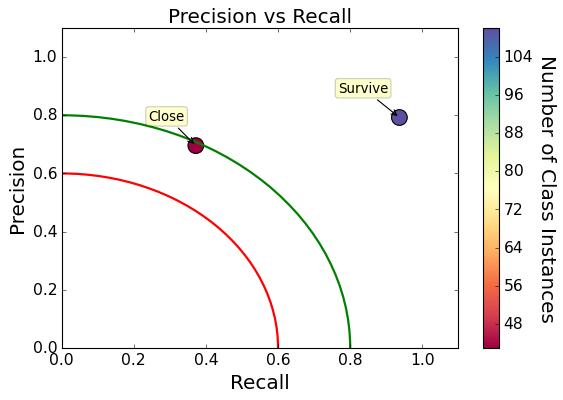

In [13]:
rpc(Y_test, 1*(y_pred>.45), labels = {0:'Close', 1:'Survive'})

In [14]:
feat_imp = list(zip(gbm.feature_name(),gbm.feature_importance()))
sorted(feat_imp, key = lambda x:-x[1])

[('LB_per_active_subject', 63),
 ('IP_variance', 51),
 ('MLB_per_active_subject', 46),
 ('SAE_per_active_subject', 40),
 ('Active_Subject_Count', 36),
 ('AE_per_active_subject', 32),
 ('ULB_per_active_subject', 22),
 ('RAE_per_active_subject', 19),
 ('SRAE_per_active_subject', 2),
 ('Missed_Dose', 0)]

In [15]:
shap=gbm.predict(X_train,  pred_contrib=True)

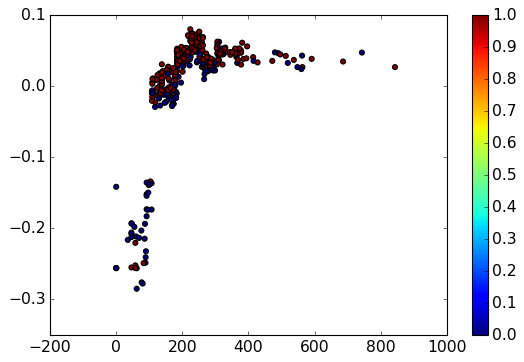

In [16]:
col=7

plt.scatter(X_train.iloc[:,col], shap[:,col], c=Y_train)
plt.colorbar()

In [17]:
feature = 7

in_bool=(Y_train == 1)
out_bool =Y_train == 0

plt.scatter(X_train[in_bool].iloc[:,feature], shap[in_bool][:,feature], c='b', label="Site Remains Active")
plt.scatter(X_train[out_bool].iloc[:,feature], shap[out_bool][:,feature], c='r', label="Site Becomes Inactive")
plt.legend()
plt.xlabel("Labs per active subject")
plt.ylabel("SHAP score (affect on model output)")

Text(0, 0.5, 'SHAP score (affect on model output)')

In [18]:
X_train.columns[7]

'LB_per_active_subject'